# This notebook introduces the sweep object

Sweep objects allowes the user the work with the QCoDeS data set in a convenient way. This includes: 

1. Registering parameters, including dependencies (e.g. which parameters are set points and which are measurement)
2. Setting set points and getting measurement values and adding them to the data set 
3. Extracting measurement data after competion in a convenient way 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qcodes import new_experiment
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument.parameter import ManualParameter
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, run, dowith

Like always, we need to start an experiment before doing anything else 

In [2]:
experiment = new_experiment("sweep_introduction", sample_name="intro")

Lets setup mock instruments 

In [3]:
x = ManualParameter("x")
y = ManualParameter("y")

m = ManualParameter("m")
m.get = lambda:np.sin(x())

n = ManualParameter("n")
n.get = lambda:np.sin(x()**2 + y())

Next, we perform a sweep where we measure both m and n. Parameter m is only dependent on set points x while n is dependent on both x and y.  

In [21]:
sweep_object = sweep(x, np.linspace(-4, 4, 100))(
    m, 
    sweep(y, np.linspace(-3, 5, 100))(
        n
    )
)

In [4]:
sweep_object.parameter_table.layout_info("m")

{'x': {'min': -4.0, 'max': 4.0, 'length': 100, 'steps': 0.080808080800000001}}

In [5]:
sweep_object.parameter_table.layout_info("n")

{'x': {'min': -4.0, 'max': 4.0, 'length': 100, 'steps': 0.080808080800000001},
 'y': {'min': -3.0, 'max': 5.0, 'length': 100, 'steps': 0.080808080800000001}}

Having the layout info before actually running the sweep is useful for live plotting. This gives us the following information: 

1. The dependancy information, e.g. "m" is dependent on "x" and "n" is dependent on "x" and "y"
2. We have the length and min/max info of the axes 

In [6]:
@dowith
def setup1(x): 
    print(f"setting up 1 with {x}")

@dowith
def setup2(x): 
    print(f"setting up 2 with {x}")

@dowith
def cleanup(): 
    print("cleaning up")

The run function takes care of making paramspecs and registering them with the data set 

In [7]:
data = run(
    [setup1.dowith(2), setup2.dowith(3)],
    sweep_object,
    [cleanup.dowith()]
)

setting up 1 with 2
setting up 2 with 3
Starting experimental run with id: 11
cleaning up


Alternatively, we can do 

```python
data = run(
    [(setup1, (2, )), (setup2, (3,))],
    sweep_object,
    [(cleanup, ())]
)
```

Some people might find the "dowith" decorator handy. 

Now that we have added data to the data set, let see how we can extract it for plotting and further processing 

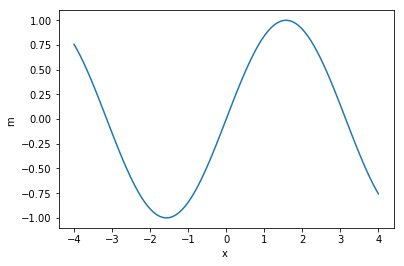

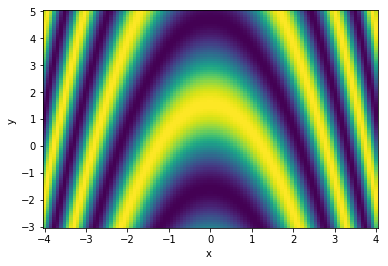

In [8]:
data.plot()

In [9]:
data.run_id

11

In [25]:
xm = data["m,x"]

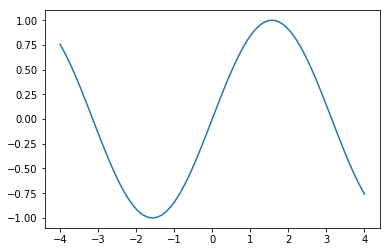

In [15]:
plt.plot(xm["x"], xm["m"])

In [22]:
xn = data["n,x"]  # data["x,n"] works just as well

In [20]:
xn.keys()

dict_keys(['x', 'y', 'n'])

In [23]:
len(xn["x"])

10000

In [26]:
len(xm["x"])

100